**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

In [126]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [127]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [128]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [129]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP with Dropout Regularisation

Use different dropout rates for the input layer (`p_in`) and hidden layers (`p_hidden`). 

In [110]:
def get_model(complexity=200, drop_p_in=.2, drop_p_hidden=.5):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p=drop_p_in),
        torch.nn.Linear(28*28, complexity),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=drop_p_hidden),
        torch.nn.Linear(complexity, 10),
        torch.nn.Sigmoid())    

In [111]:
model = get_model()

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
           Sigmoid-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
           Sigmoid-7                   [-1, 10]               0
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### Training

Implement the training / evaluation loop

Remember and return training / validation cost and accuracy per epoch. 

In [144]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data=None, training_sampler=None, validation_sampler=None):
    training_cost_hist = []; validation_cost_hist = [];
    validation_acc_hist = []; training_acc_hist = [];

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    if validation_data is None:
        if training_sampler is None or validation_sampler is None:
            print("supply either validation data or samplers")
            return
        validation_loader = DataLoader(training_data, batch_size=nbatch, sampler=validation_sampler)
        training_loader = DataLoader(training_data, batch_size=nbatch, sampler=training_sampler)
    else:
        if training_sampler is not None or validation_sampler is not None:
            print("supply either validation data or samplers")
            return
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    
    for epoch in range(nepochs):
        model.train()
        training_cost, correct = 0.0, 0.0
        for inputs, targets in training_loader:
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            training_cost += cost.item()
            correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        training_cost /= len(training_loader)
        training_acc = correct / len(training_loader.dataset)

        model.eval()
        validation_cost, correct = 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                predictions = model(inputs)
                validation_cost += cost_ce(predictions, targets).item()
                correct += (torch.argmax(predictions, dim=1) == targets).sum()
        validation_cost /= len(validation_loader)
        validation_acc = correct / len(validation_loader.dataset)
        
        training_cost_hist.append(training_cost)
        training_acc_hist.append(training_acc)
        validation_cost_hist.append(validation_cost)
        validation_acc_hist.append(validation_acc)
        print("Epoch {:2}: {:.2f}, {:.2f}, {:.2f}, {:.2f}"
              .format(epoch, training_cost, validation_cost, training_acc, validation_acc))
    
    return training_cost_hist, validation_cost_hist, training_acc_hist, validation_acc_hist

### Analyse Different Settings

Start with a baseline model: 200 units in a single hidden layer; batch size 64; properly tuned learning rate, no dropout.

Then play with different model complexities and dropout rates and compare them on the basis of the validation set.

Estimate also the variance error by the difference between validation and training loss / accuracy.

Finally, identify a favourite combination (model complexity, dropout rate) and compute the test accuracy. 


In [8]:
costs = {"train":[], "valid":[]}
accs =  {"train":[], "valid":[]}

In [9]:
nbatch = 64
nepochs = 75
lr = 0.5

complexity = [100, 200, 300]
drop_p = [0, 0.3, 0.6]

hists = [costs["train"], costs["valid"], accs["train"], accs["valid"]]

for c in complexity:
    for p in drop_p:
        print(f"######## complexity: {c}, dropout rate: {p}")
        model = get_model(complexity=c, drop_p_in=p, drop_p_hidden=p)
        res = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)
        [hist.append(val) for (hist, val) in zip(hists, res)]

######## complexity: 100, dropout rate: 0
Epoch  0: 1.83, 1.71, 0.46, 0.53
Epoch  1: 1.69, 1.68, 0.50, 0.49
Epoch  2: 1.67, 1.66, 0.48, 0.47
Epoch  3: 1.66, 1.65, 0.47, 0.48
Epoch  4: 1.65, 1.65, 0.48, 0.48
Epoch  5: 1.64, 1.64, 0.48, 0.49
Epoch  6: 1.64, 1.64, 0.49, 0.50
Epoch  7: 1.64, 1.64, 0.50, 0.50
Epoch  8: 1.63, 1.63, 0.50, 0.50
Epoch  9: 1.63, 1.63, 0.51, 0.50
Epoch 10: 1.63, 1.63, 0.51, 0.51
Epoch 11: 1.62, 1.63, 0.51, 0.51
Epoch 12: 1.62, 1.62, 0.52, 0.53
Epoch 13: 1.62, 1.62, 0.52, 0.52
Epoch 14: 1.62, 1.62, 0.53, 0.52
Epoch 15: 1.62, 1.62, 0.53, 0.53
Epoch 16: 1.61, 1.62, 0.54, 0.53
Epoch 17: 1.61, 1.61, 0.55, 0.54
Epoch 18: 1.61, 1.61, 0.55, 0.54
Epoch 19: 1.61, 1.61, 0.56, 0.57
Epoch 20: 1.61, 1.61, 0.57, 0.57
Epoch 21: 1.61, 1.61, 0.58, 0.58
Epoch 22: 1.60, 1.61, 0.59, 0.61
Epoch 23: 1.60, 1.61, 0.60, 0.60
Epoch 24: 1.60, 1.61, 0.60, 0.61
Epoch 25: 1.60, 1.61, 0.62, 0.63
Epoch 26: 1.60, 1.61, 0.62, 0.62
Epoch 27: 1.60, 1.61, 0.63, 0.63
Epoch 28: 1.60, 1.61, 0.64, 0.64
E

Epoch 19: 1.61, 1.60, 0.67, 0.71
Epoch 20: 1.60, 1.60, 0.71, 0.70
Epoch 21: 1.60, 1.60, 0.72, 0.75
Epoch 22: 1.60, 1.60, 0.74, 0.76
Epoch 23: 1.59, 1.60, 0.76, 0.77
Epoch 24: 1.59, 1.60, 0.77, 0.76
Epoch 25: 1.59, 1.59, 0.78, 0.79
Epoch 26: 1.58, 1.59, 0.79, 0.79
Epoch 27: 1.58, 1.59, 0.79, 0.79
Epoch 28: 1.58, 1.58, 0.80, 0.80
Epoch 29: 1.58, 1.58, 0.81, 0.81
Epoch 30: 1.57, 1.58, 0.82, 0.81
Epoch 31: 1.57, 1.57, 0.82, 0.81
Epoch 32: 1.57, 1.57, 0.82, 0.81
Epoch 33: 1.57, 1.57, 0.83, 0.81
Epoch 34: 1.56, 1.57, 0.83, 0.82
Epoch 35: 1.56, 1.57, 0.83, 0.83
Epoch 36: 1.56, 1.57, 0.84, 0.84
Epoch 37: 1.56, 1.57, 0.85, 0.84
Epoch 38: 1.56, 1.57, 0.85, 0.84
Epoch 39: 1.56, 1.57, 0.85, 0.85
Epoch 40: 1.56, 1.57, 0.85, 0.85
Epoch 41: 1.56, 1.57, 0.86, 0.85
Epoch 42: 1.55, 1.56, 0.86, 0.85
Epoch 43: 1.55, 1.56, 0.86, 0.85
Epoch 44: 1.55, 1.56, 0.86, 0.85
Epoch 45: 1.55, 1.56, 0.86, 0.86
Epoch 46: 1.55, 1.57, 0.86, 0.84
Epoch 47: 1.55, 1.56, 0.86, 0.86
Epoch 48: 1.55, 1.56, 0.86, 0.86
Epoch 49: 

Epoch 39: 1.56, 1.56, 0.85, 0.85
Epoch 40: 1.55, 1.56, 0.86, 0.85
Epoch 41: 1.55, 1.56, 0.86, 0.85
Epoch 42: 1.55, 1.56, 0.86, 0.85
Epoch 43: 1.55, 1.56, 0.86, 0.85
Epoch 44: 1.55, 1.56, 0.86, 0.85
Epoch 45: 1.55, 1.56, 0.86, 0.85
Epoch 46: 1.55, 1.56, 0.86, 0.86
Epoch 47: 1.55, 1.56, 0.86, 0.85
Epoch 48: 1.55, 1.56, 0.86, 0.86
Epoch 49: 1.55, 1.56, 0.86, 0.86
Epoch 50: 1.55, 1.56, 0.86, 0.85
Epoch 51: 1.55, 1.56, 0.86, 0.86
Epoch 52: 1.55, 1.56, 0.86, 0.86
Epoch 53: 1.55, 1.56, 0.86, 0.86
Epoch 54: 1.55, 1.56, 0.86, 0.86
Epoch 55: 1.55, 1.56, 0.86, 0.85
Epoch 56: 1.55, 1.56, 0.86, 0.86
Epoch 57: 1.55, 1.56, 0.86, 0.86
Epoch 58: 1.55, 1.56, 0.87, 0.86
Epoch 59: 1.54, 1.56, 0.87, 0.86
Epoch 60: 1.54, 1.55, 0.87, 0.86
Epoch 61: 1.54, 1.55, 0.87, 0.86
Epoch 62: 1.54, 1.55, 0.87, 0.86
Epoch 63: 1.54, 1.56, 0.87, 0.86
Epoch 64: 1.54, 1.55, 0.87, 0.86
Epoch 65: 1.54, 1.55, 0.87, 0.86
Epoch 66: 1.54, 1.55, 0.87, 0.86
Epoch 67: 1.54, 1.56, 0.87, 0.86
Epoch 68: 1.54, 1.55, 0.87, 0.86
Epoch 69: 

### Suitable Output Plots

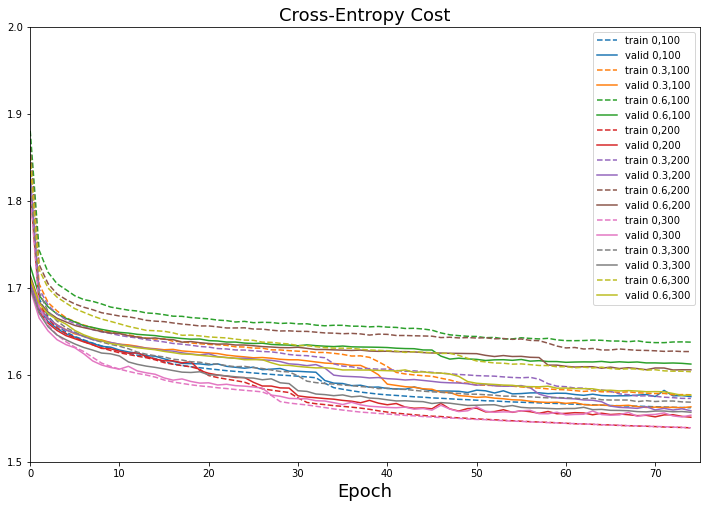

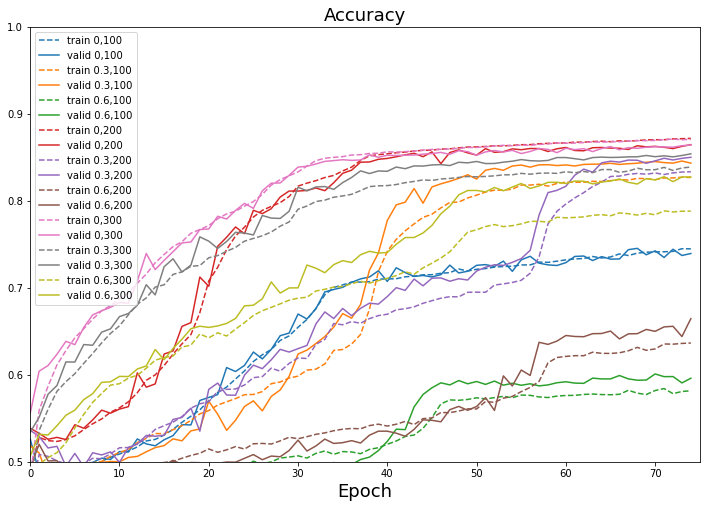

In [16]:
plt.figure(1, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), costs["train"][i], color=f"C{i}", linestyle="--", label=f"train {p},{c}")
        plt.plot(torch.arange(nepochs), costs["valid"][i], color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.ylim(1.5, 2)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend()
plt.figure(2, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), accs["train"][i], color=f"C{i}", linestyle="--", label=f"train {p},{c}")
        plt.plot(torch.arange(nepochs), accs["valid"][i], color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.ylim(0.5, 1.0)
plt.title("Accuracy", fontsize=18)
plt.legend()
plt.show()

# Variance

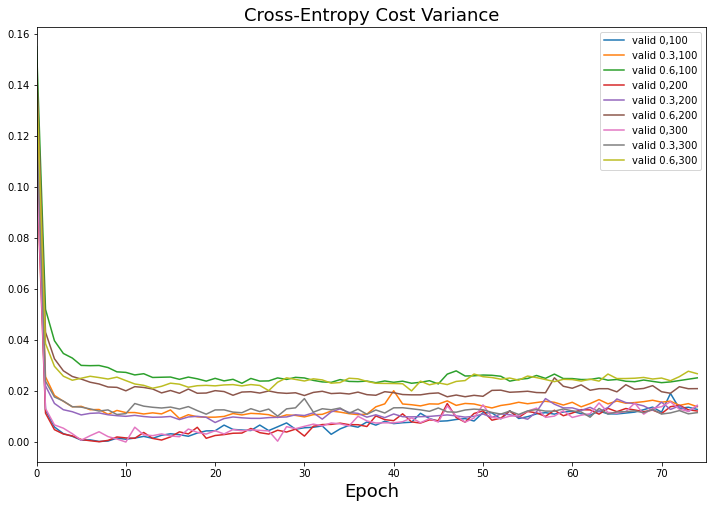

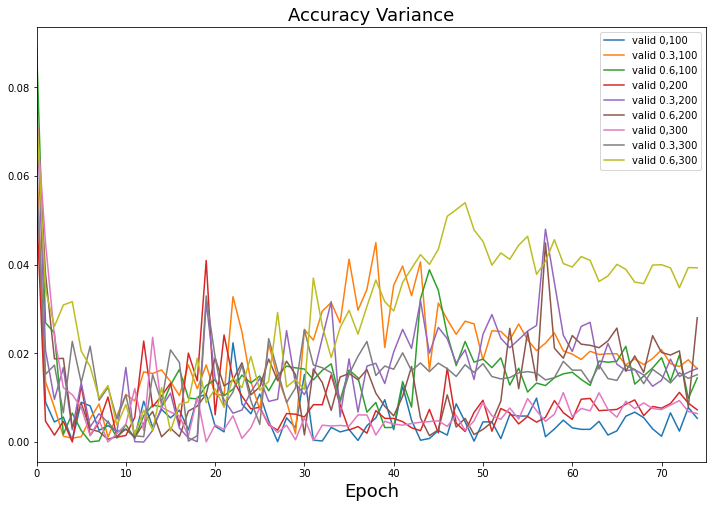

In [27]:
plt.figure(1, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), abs(np.array(costs["valid"][i]) - np.array(costs["train"][i])),
                 color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
#plt.ylim(1.5, 2)
plt.title("Cross-Entropy Cost Variance", fontsize=18)
plt.legend()
plt.figure(2, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), abs(np.array(accs["valid"][i]) - np.array(accs["train"][i])),
                 color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
#plt.ylim(0.5, 1.0)
plt.title("Accuracy Variance", fontsize=18)
plt.legend()
plt.show()

In [145]:
nbatch = 64
nepochs = 40
lr = 0.5
model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)
res = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)

Epoch  0: 1.82, 1.71, 0.47, 0.52
Epoch  1: 1.69, 1.68, 0.54, 0.54
Epoch  2: 1.67, 1.66, 0.56, 0.57
Epoch  3: 1.66, 1.65, 0.58, 0.58
Epoch  4: 1.65, 1.65, 0.59, 0.58
Epoch  5: 1.65, 1.64, 0.60, 0.62
Epoch  6: 1.64, 1.64, 0.61, 0.61
Epoch  7: 1.64, 1.63, 0.62, 0.64
Epoch  8: 1.64, 1.63, 0.63, 0.63
Epoch  9: 1.63, 1.63, 0.64, 0.65
Epoch 10: 1.63, 1.63, 0.65, 0.65
Epoch 11: 1.63, 1.62, 0.66, 0.66
Epoch 12: 1.63, 1.62, 0.67, 0.66
Epoch 13: 1.62, 1.62, 0.68, 0.67
Epoch 14: 1.62, 1.61, 0.68, 0.68
Epoch 15: 1.62, 1.61, 0.69, 0.69
Epoch 16: 1.62, 1.61, 0.70, 0.70
Epoch 17: 1.62, 1.61, 0.71, 0.71
Epoch 18: 1.62, 1.61, 0.71, 0.71
Epoch 19: 1.61, 1.61, 0.72, 0.73
Epoch 20: 1.61, 1.61, 0.72, 0.72
Epoch 21: 1.61, 1.60, 0.73, 0.73
Epoch 22: 1.61, 1.60, 0.74, 0.74
Epoch 23: 1.61, 1.60, 0.74, 0.75
Epoch 24: 1.61, 1.60, 0.74, 0.76
Epoch 25: 1.61, 1.60, 0.75, 0.76
Epoch 26: 1.61, 1.60, 0.76, 0.77
Epoch 27: 1.61, 1.60, 0.76, 0.77
Epoch 28: 1.60, 1.59, 0.76, 0.77
Epoch 29: 1.60, 1.59, 0.77, 0.78
Epoch 30: 

In [146]:
test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=True)
model.eval()
correct = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        correct += (torch.argmax(predictions, dim=1) == targets).sum()
test_acc = correct / len(test_loader.dataset)
test_acc

tensor(0.8268)

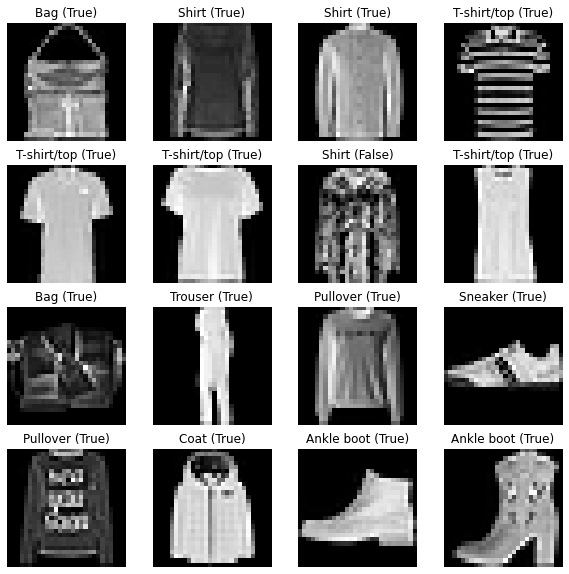

In [147]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    img, label = training_data[randint(len(training_data))]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    prediction = model(img).argmax()
    plt.title(f"{training_data.dataset.classes[model(img).argmax()]} ({prediction == label})" )
    plt.axis("off")

# Exercise 3: 5-Fold Cross Validation

In [148]:
from sklearn.model_selection import KFold
cross_val_training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

In [149]:
nepochs = 20
k = 5 # 10
kf = KFold(n_splits=k, shuffle=True)
cross_val_acc_hists = []
for train_idx, valid_idx in kf.split(cross_val_training_data):
    model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)
    _, _, _, cross_val_acc_hist = train_eval(
        model, lr, nepochs, nbatch, cross_val_training_data, training_sampler=train_idx, validation_sampler=valid_idx)
    cross_val_acc_hists.append(cross_val_acc_hist)

Epoch  0: 1.83, 1.70, 0.38, 0.11
Epoch  1: 1.70, 1.67, 0.44, 0.11
Epoch  2: 1.67, 1.66, 0.46, 0.12
Epoch  3: 1.66, 1.65, 0.47, 0.12
Epoch  4: 1.66, 1.64, 0.48, 0.12
Epoch  5: 1.65, 1.64, 0.49, 0.12
Epoch  6: 1.64, 1.63, 0.50, 0.13
Epoch  7: 1.64, 1.63, 0.50, 0.13
Epoch  8: 1.64, 1.63, 0.51, 0.13
Epoch  9: 1.63, 1.62, 0.52, 0.13
Epoch 10: 1.63, 1.62, 0.53, 0.13
Epoch 11: 1.63, 1.61, 0.54, 0.13
Epoch 12: 1.63, 1.61, 0.54, 0.14
Epoch 13: 1.62, 1.61, 0.55, 0.14
Epoch 14: 1.62, 1.61, 0.55, 0.14
Epoch 15: 1.62, 1.61, 0.56, 0.14
Epoch 16: 1.62, 1.61, 0.57, 0.14
Epoch 17: 1.62, 1.60, 0.57, 0.14
Epoch 18: 1.62, 1.60, 0.58, 0.15
Epoch 19: 1.61, 1.60, 0.58, 0.15
Epoch  0: 1.83, 1.70, 0.37, 0.11
Epoch  1: 1.70, 1.67, 0.42, 0.11
Epoch  2: 1.68, 1.66, 0.44, 0.12
Epoch  3: 1.66, 1.65, 0.46, 0.12
Epoch  4: 1.66, 1.64, 0.47, 0.12
Epoch  5: 1.65, 1.64, 0.48, 0.12
Epoch  6: 1.65, 1.63, 0.49, 0.13
Epoch  7: 1.64, 1.63, 0.50, 0.13
Epoch  8: 1.64, 1.63, 0.51, 0.13
Epoch  9: 1.64, 1.62, 0.52, 0.13
Epoch 10: 

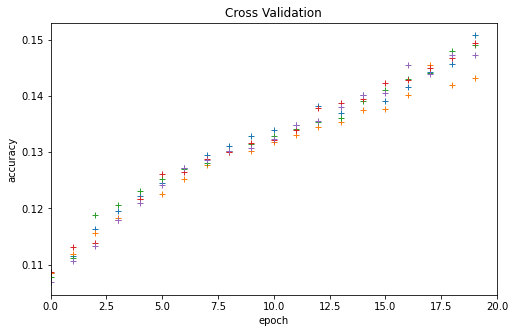

In [151]:
plt.figure()
for i in range(k):
    plt.plot(torch.arange(nepochs), cross_val_acc_hists[i], "+", color=f"C{i}")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, nepochs)
plt.title("Cross Validation")
plt.show()